In [ ]:
!cp "./drive/MyDrive/cs523_project/images_test.zip" ./
!cp "./drive/MyDrive/cs523_project/labels_test.zip" ./
!unzip -q "./images_test.zip"
!unzip -q "./labels_test.zip"

In [ ]:
!nvidia-smi

Thu Apr 28 13:30:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import numpy as np
import cv2
import json
import random
import matplotlib.pyplot as plt
import torchvision
from scipy import stats

from PIL import Image


# set plot size
def set_plot_size(name):
    # (w, h)
    if name == "wide":
        plt.rcParams["figure.figsize"] = (30, 4)
        return
    if name == "big":
        plt.rcParams["figure.figsize"] = (30, 10)  # (w, h)
        return
    plt.rcParams["figure.figsize"] = (6, 4)  # normal


# modified from https://github.com/whai362/PSENet/blob/python2/models/fpn_resnet.py
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


# noinspection PyMethodMayBeStatic
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=7, scale=1):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.avgpool = nn.AvgPool2d(7, stride=1)
        # self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Top layer
        self.toplayer = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)  # Reduce channels
        self.toplayer_bn = nn.BatchNorm2d(256)
        self.toplayer_relu = nn.ReLU(inplace=True)

        # Smooth layers
        self.smooth1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth1_bn = nn.BatchNorm2d(256)
        self.smooth1_relu = nn.ReLU(inplace=True)

        self.smooth2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth2_bn = nn.BatchNorm2d(256)
        self.smooth2_relu = nn.ReLU(inplace=True)

        self.smooth3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.smooth3_bn = nn.BatchNorm2d(256)
        self.smooth3_relu = nn.ReLU(inplace=True)

        # Lateral layers
        self.latlayer1 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer1_bn = nn.BatchNorm2d(256)
        self.latlayer1_relu = nn.ReLU(inplace=True)

        self.latlayer2 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer2_bn = nn.BatchNorm2d(256)
        self.latlayer2_relu = nn.ReLU(inplace=True)

        self.latlayer3 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.latlayer3_bn = nn.BatchNorm2d(256)
        self.latlayer3_relu = nn.ReLU(inplace=True)

        self.conv2_changed = nn.Conv2d(1024, 256, kernel_size=3, stride=1, padding=1)
        self.bn2_changed = nn.BatchNorm2d(256)
        self.relu2_changed = nn.ReLU(inplace=True)
        self.conv3_changed = nn.Conv2d(256, num_classes, kernel_size=1, stride=1, padding=0)

        self.scale = scale

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    # noinspection PyListCreation
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _upsample(self, x, y, scale=1):
        # noinspection PyPep8Naming
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H // scale, W // scale), mode='bilinear', align_corners=True)

    def _upsample_add(self, x, y):
        # noinspection PyPep8Naming
        _, _, H, W = y.size()
        return F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True) + y

    def forward(self, x):
        h = x
        h = self.conv1(h)
        h = self.bn1(h)
        h = self.relu1(h)
        h = self.maxpool(h)

        h = self.layer1(h)
        c2 = h
        h = self.layer2(h)
        c3 = h
        h = self.layer3(h)
        c4 = h
        h = self.layer4(h)
        c5 = h

        # Top-down
        p5 = self.toplayer(c5)
        p5 = self.toplayer_relu(self.toplayer_bn(p5))

        c4 = self.latlayer1(c4)
        c4 = self.latlayer1_relu(self.latlayer1_bn(c4))
        p4 = self._upsample_add(p5, c4)
        p4 = self.smooth1(p4)
        p4 = self.smooth1_relu(self.smooth1_bn(p4))

        c3 = self.latlayer2(c3)
        c3 = self.latlayer2_relu(self.latlayer2_bn(c3))
        p3 = self._upsample_add(p4, c3)
        p3 = self.smooth2(p3)
        p3 = self.smooth2_relu(self.smooth2_bn(p3))

        c2 = self.latlayer3(c2)
        c2 = self.latlayer3_relu(self.latlayer3_bn(c2))
        p2 = self._upsample_add(p3, c2)
        p2 = self.smooth3(p2)
        p2 = self.smooth3_relu(self.smooth3_bn(p2))

        p3 = self._upsample(p3, p2)
        p4 = self._upsample(p4, p2)
        p5 = self._upsample(p5, p2)

        out = torch.cat((p2, p3, p4, p5), 1)
        out = self.conv2_changed(out)
        out = self.relu2_changed(self.bn2_changed(out))
        out = self.conv3_changed(out)
        out = self._upsample(out, x, scale=self.scale)

        return out


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_model = model_zoo.load_url(model_urls['resnet50'])
        state = model.state_dict()
        for key in state.keys():
            if key in pretrained_model.keys():
                state[key] = pretrained_model[key]
        model.load_state_dict(state)
    return model



# PSE algorithm
import numpy as np
import cv2
from queue import Queue


def pse(kernals, min_area):
    kernal_num = len(kernals)
    # print('kernal_num', kernal_num)
    pred = np.zeros(kernals[0].shape, dtype='int32')

    label_num, label = cv2.connectedComponents(kernals[kernal_num - 1], connectivity=4)

    for label_idx in range(1, label_num):
        if np.sum(label == label_idx) < min_area:
            label[label == label_idx] = 0

    queue = Queue(maxsize=0)
    next_queue = Queue(maxsize=0)
    points = np.array(np.where(label > 0)).transpose((1, 0))

    for point_idx in range(points.shape[0]):
        x, y = points[point_idx, 0], points[point_idx, 1]
        l = label[x, y]
        queue.put((x, y, l))
        pred[x, y] = l

    dx = [-1, 1, 0, 0]
    dy = [0, 0, -1, 1]
    for kernal_idx in range(kernal_num - 2, -1, -1):
        kernal = kernals[kernal_idx].copy()
        while not queue.empty():
            (x, y, l) = queue.get()

            is_edge = True
            for j in range(4):
                tmpx = x + dx[j]
                tmpy = y + dy[j]
                if tmpx < 0 or tmpx >= kernal.shape[0] or tmpy < 0 or tmpy >= kernal.shape[1]:
                    continue
                if kernal[tmpx, tmpy] == 0 or pred[tmpx, tmpy] > 0:
                    continue

                queue.put((tmpx, tmpy, l))
                pred[tmpx, tmpy] = l
                is_edge = False
            if is_edge:
                next_queue.put((x, y, l))

        # kernal[pred > 0] = 0
        queue, next_queue = next_queue, queue

        # points = np.array(np.where(pred > 0)).transpose((1, 0))
        # for point_idx in range(points.shape[0]):
        #     x, y = points[point_idx, 0], points[point_idx, 1]
        #     l = pred[x, y]
        #     queue.put((x, y, l))

    return pred


# mask to polygon
def mask2plg(mask):
    contours = cv2.findContours(mask.astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
    return contours[0].squeeze()


# mask to confidence
def mask2conf(mask, raw):
    canvas_conf = raw[0][4].copy()
    return canvas_conf[mask].mean()


# mask to category
def mask2category(mask, raw):
    canvas_category = np.argmax(raw[0, 0:4], axis=0).astype("int32")
    return stats.mode(canvas_category[mask])[0][0]


# test mask2plg
# mask = result_pse == 14
# plt.imshow(mask)
# plt.show()
# plg = mask2plg(mask)
# canvas = np.zeros((512, 910), dtype="uint8")
# canvas = cv2.drawContours(canvas, [plg], 0, 1, -1)
# plt.imshow(canvas)
# plt.show()


# test mask2conf
# mask = result_pse == 1
# print(mask2conf(mask, raw))


# by Junyi
import numpy as np
import time
from shapely.geometry import Polygon
import scipy.io as io

def Cal_area_2poly(data1,data2):
  """
  calculate inter area between two polygons
  :param data1: list of points
  :param data2: list of points
  :return area
  """

  poly1 = Polygon(data1).convex_hull# Polygon：
  poly2 = Polygon(data2).convex_hull

  if not poly1.intersects(poly2):
    inter_area = 0  # if they don't interact
  else:
    inter_area = poly1.intersection(poly2).area

  return inter_area

def Compute_iou(pre, label):
  #pre = [[x1,y1],[x2,y2].....]
  #label = [[x1,y1],[x2,y2].....]
  pre_area = Polygon(pre).area
  label_area = Polygon(label).area
  inter_area = Cal_area_2poly(pre, label)

  iou = inter_area/(pre_area+label_area-inter_area)

  return iou

def Average_precision(pres, labels, iou_threshold):
  '''
  pres = [[pre1,confidence1],[pre2,confidence2],......]
  labels = [label1,label2,.....]
  '''
  all_GT_num = len(labels)
  compare_res_list = []#[[pre,confidence,GT]], if iou>threshold, GT = 1
  for label in labels:
    iou_max = 0
    GT = 0
    max_list = None
    for pre in pres:
      pre_list = pre[0].tolist()
      label_list = label.tolist()

      iou = Compute_iou(pre_list,label_list)

      if iou>=iou_threshold and iou>iou_max:
        GT = 1
        max_list = pre_list
        confidence = pre[1]
    if max_list is not None:
      compare_res_list.append([max_list,confidence,GT])
  compare_res_list.sort(key = lambda x:x[1],reverse=True)
  
  TP = 0
  FP = 0
  precision_and_recall_list = []
  for pre in compare_res_list:
    if pre[2]==1:
      TP+=1
    else:
      FP+=1
    precision = TP/(TP+FP)
    recall = TP/all_GT_num
    precision_and_recall_list.append([precision,recall])

  #print(precision_and_recall_list)
  
  AP = 0
  prev_recall = 0
  for PandC in precision_and_recall_list:
    #AP = (recall-previous_recall)*precision
    AP+=(PandC[1]-prev_recall)*PandC[0]
    prev_recall = PandC[1]

  return AP
poly1=np.array([[1,0],[0,1],[0,0],[1,1]])
poly2=np.array([[0.5,0.5],[0.5,1.5],[1.5,1.5],[1.5,0.5]])

poly3 = np.array([[7,7],[8,8],[7,8],[8,7]])
poly4 = np.array([[6.5,6.5],[7.5,8.5],[8.5,8.5],[8.5,7.5]])

pres = [[poly1,0.9],[poly3,0.8]]
labels = [poly2,poly4]

print(Average_precision(pres,labels,0.5))

0.5


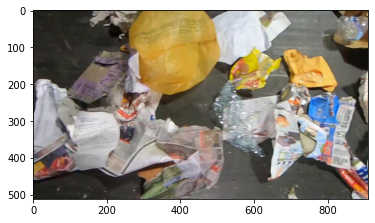

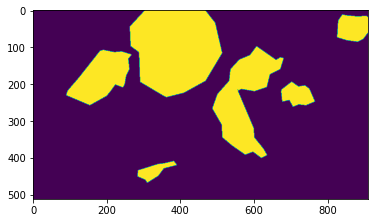

In [ ]:
import pickle

img = Image.open("./images/00000.jpg")
img = np.array(img, dtype="uint8")
plt.imshow(img)
plt.show()

with open("./labels/00000.pkl", "rb") as f:
    tmp = pickle.load(f)

canvas = np.zeros((512, 910), dtype="uint8")
for idx in range(len(tmp)):
    tmp_tmp = np.array(tmp[idx][0]).reshape((-1, 2))
    tmp_tmp = (tmp_tmp / 2.1).astype("int")
    canvas = cv2.drawContours(canvas, [tmp_tmp], 0, 1, -1)

plt.imshow(canvas)

In [ ]:
model = resnet50(pretrained=True, num_classes=7).cuda()
model.load_state_dict(torch.load("./drive/MyDrive/cs523_project/saved_model_0"))

<All keys matched successfully>

In [ ]:
info_prediction_all = list()
info_label_all = list()

for idx_test in range(929):
    try:
        name_test = str(idx_test).zfill(5)
        img_path = "./images/" + name_test + ".jpg"
        path_label = "./labels/" + name_test + ".pkl"

        to_tensor = torchvision.transforms.ToTensor()
        normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        image = Image.open(img_path)
        image = to_tensor(image)
        image = normalize(image)

        x = image[None].cuda()

        model.eval()
        y = model(x)
        y = torch.sigmoid(y)

        y = y.detach().cpu().numpy()
        raw = y.copy()
        thr = 0.5
        y[y > thr] = 1
        y[y <= thr] = 0

        kernels = np.zeros((3, 512, 910), dtype="uint8")

        kernels[0] = y[0, 4]
        kernels[1] = y[0, 5]
        kernels[2] = y[0, 6]

        result_pse = pse(kernels, 100)

        with open(path_label, "rb") as f:
            label_tmp = pickle.load(f)


        # get info_prediction and info_label
        num_plg = result_pse.max()
        info_prediction = list()
        for idx_plg in range(num_plg):
            mask = result_pse == idx_plg + 1
            if (mask.sum() == 0):
                continue
            plg = mask2plg(mask)
            conf = mask2conf(mask, raw)
            category = mask2category(mask, raw)
            info_prediction.append((conf, category, plg))


        info_label = list()
        for idx_label_tmp in range(len(label_tmp)):
            tmp = label_tmp[idx_label_tmp]
            plg = (np.array(tmp[0], dtype="int32").reshape((-1, 2)) / 2.1).astype(int)
            category = tmp[1]
            info_label.append((category, plg))

        info_prediction_all.append(info_prediction)
        info_label_all.append(info_label)

        if (idx_test + 1) % 10 == 0:
            print(idx_test + 1)
    except:
        pass

In [ ]:
ap_final = 0
for category_id in range(4):
    ap_sum = 0
    counter = 0

    for idx in range(len(info_prediction_all)):
        info_prediction = info_prediction_all[idx]
        info_label = info_label_all[idx]
        
        list_ap_pred = [[tmp[2], tmp[0]] for tmp in info_prediction if tmp[1] == category_id]
        # print(len(list_ap_pred))
        list_ap_label = [tmp[1] for tmp in info_label if tmp[0] == category_id]

        ap_current = Average_precision(list_ap_pred, list_ap_label, 0.5)
        # print("AP:", ap_current)
        ap_sum += ap_current
        counter += 1

    ap_final += ap_sum / counter

ap_final / 4

0.2096178069807638

0


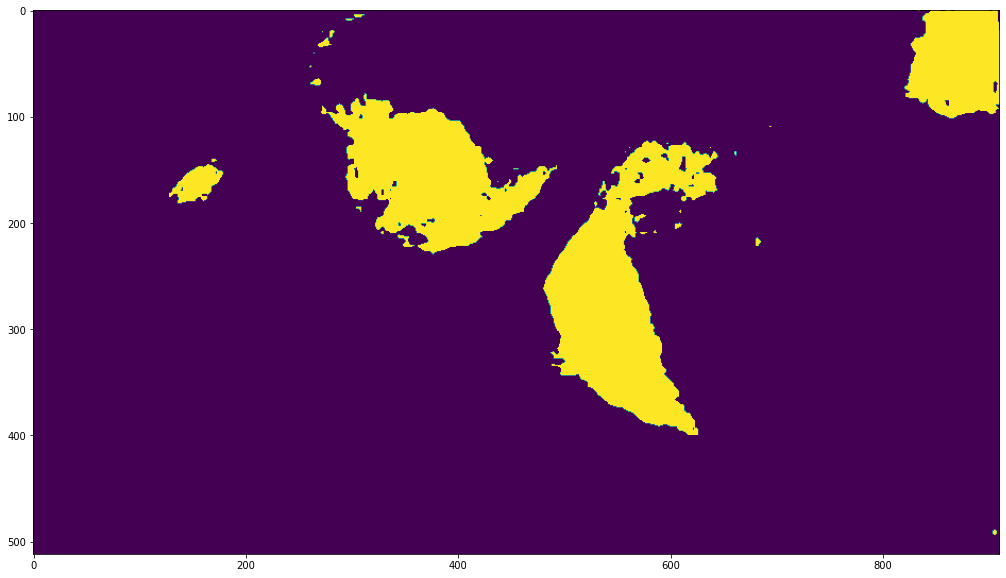

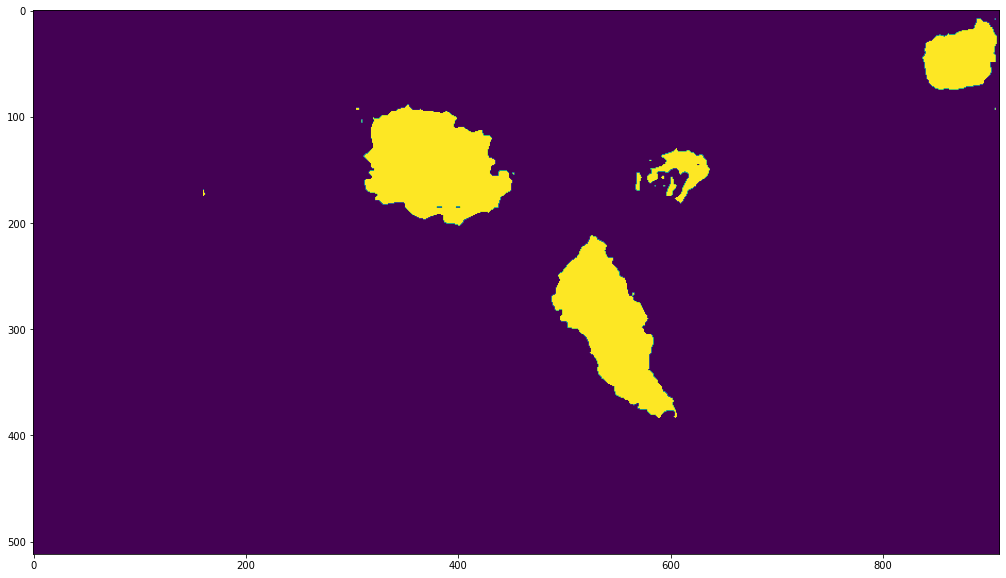

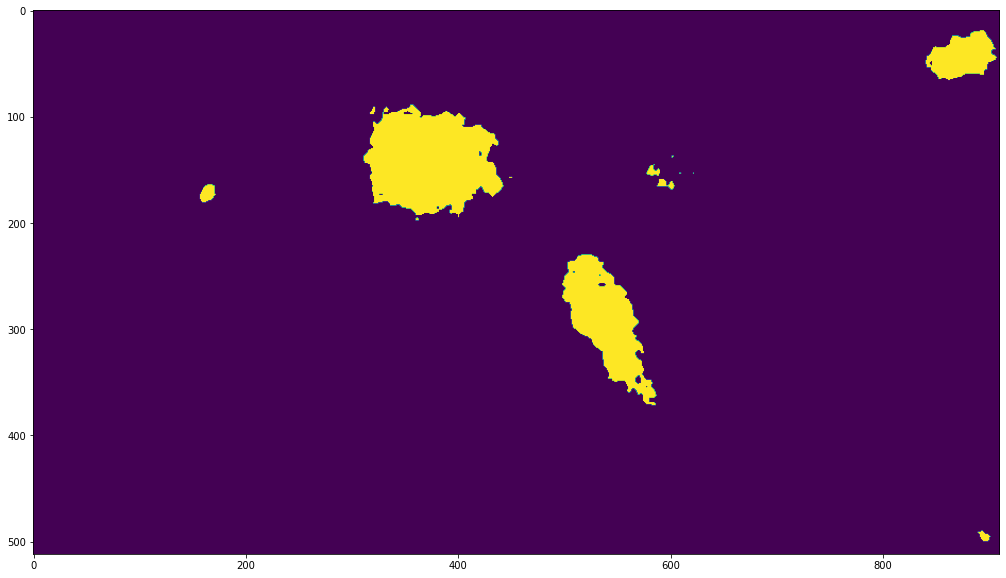

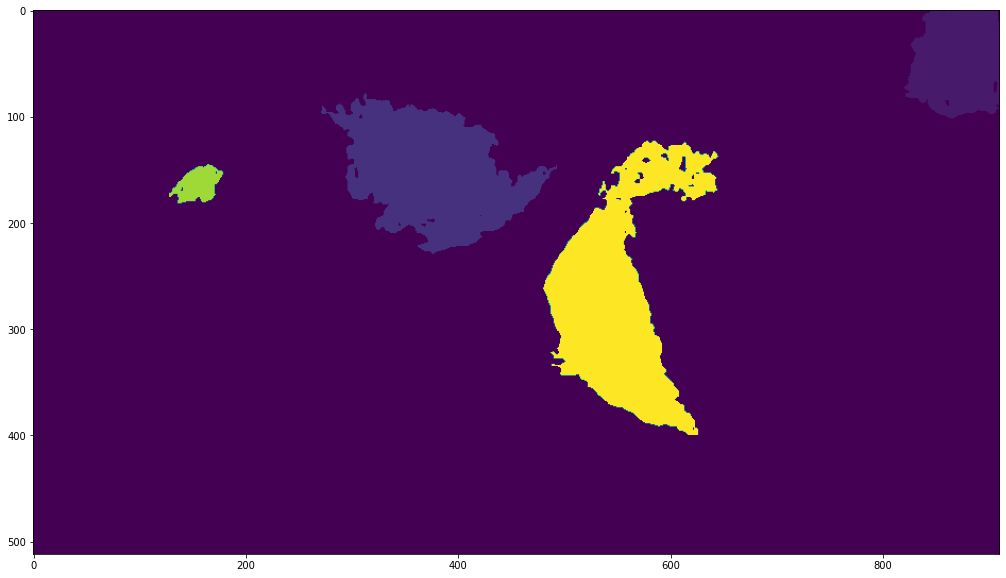

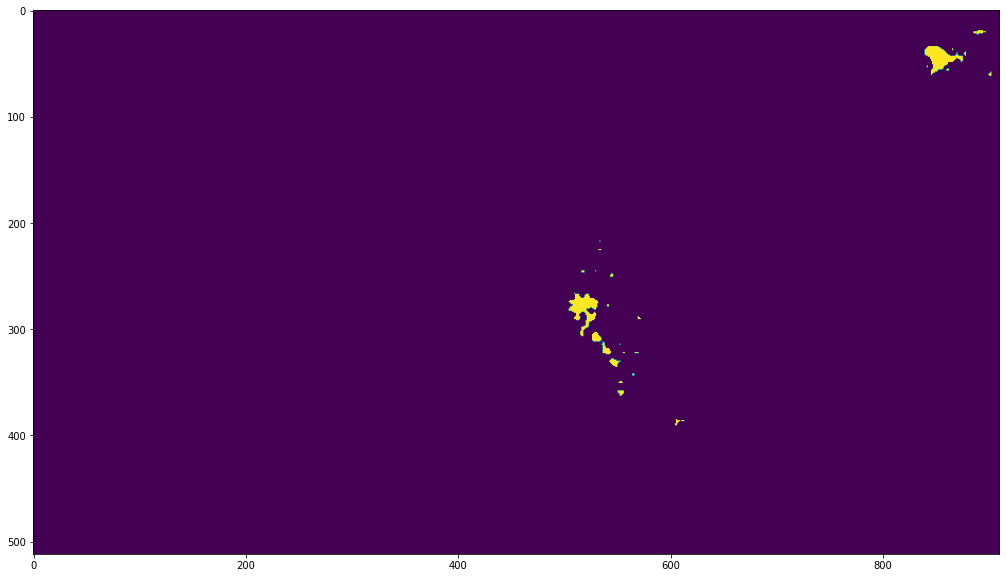

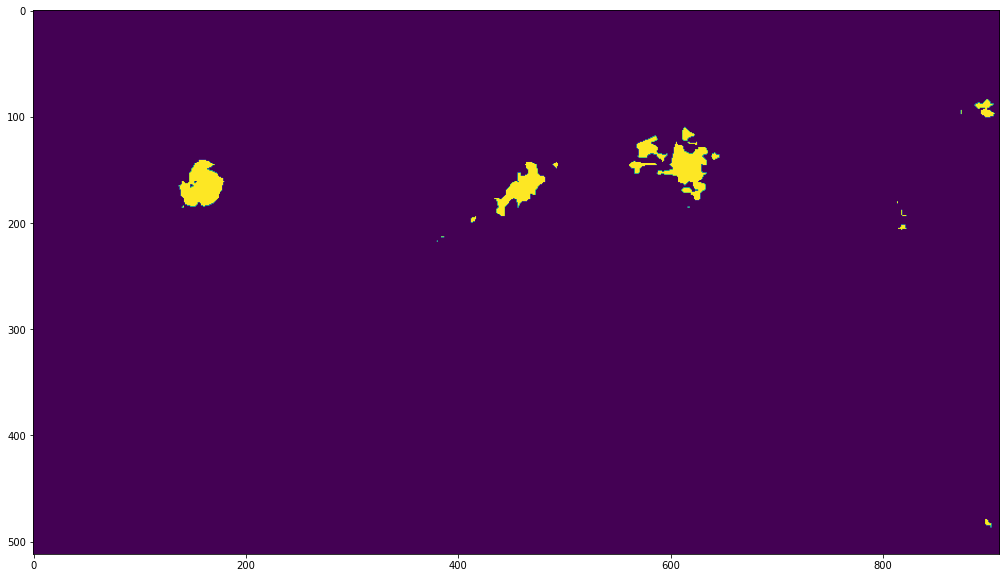

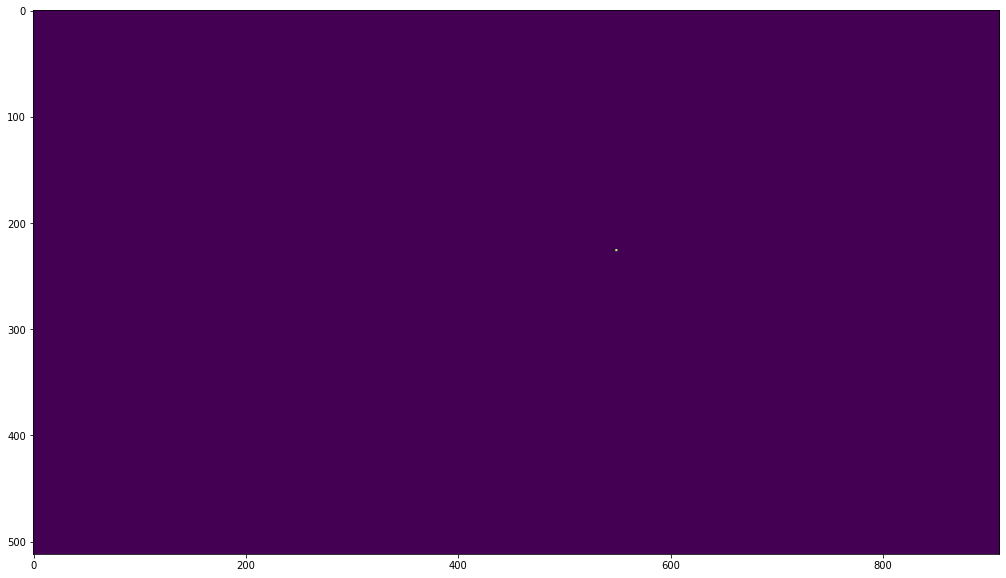

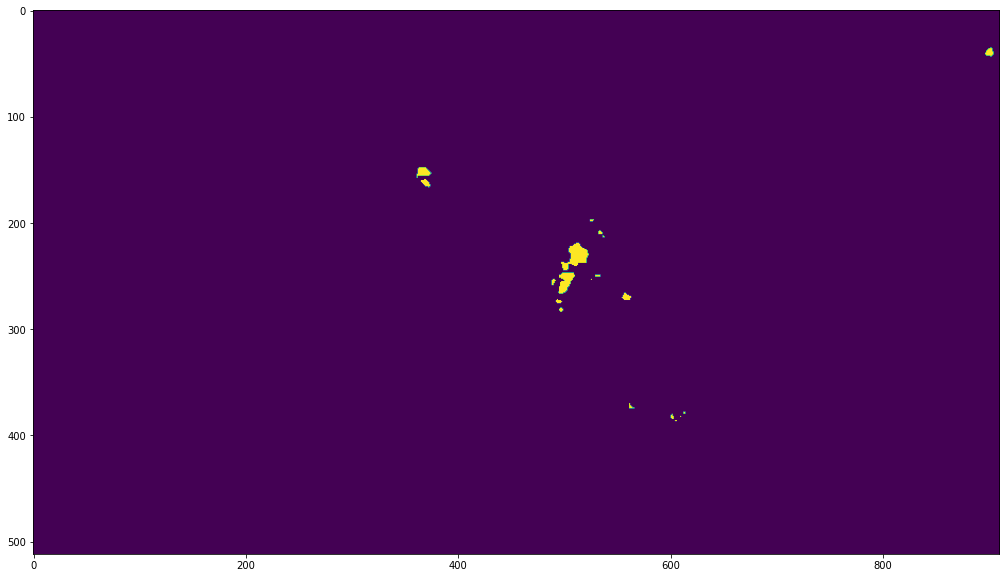

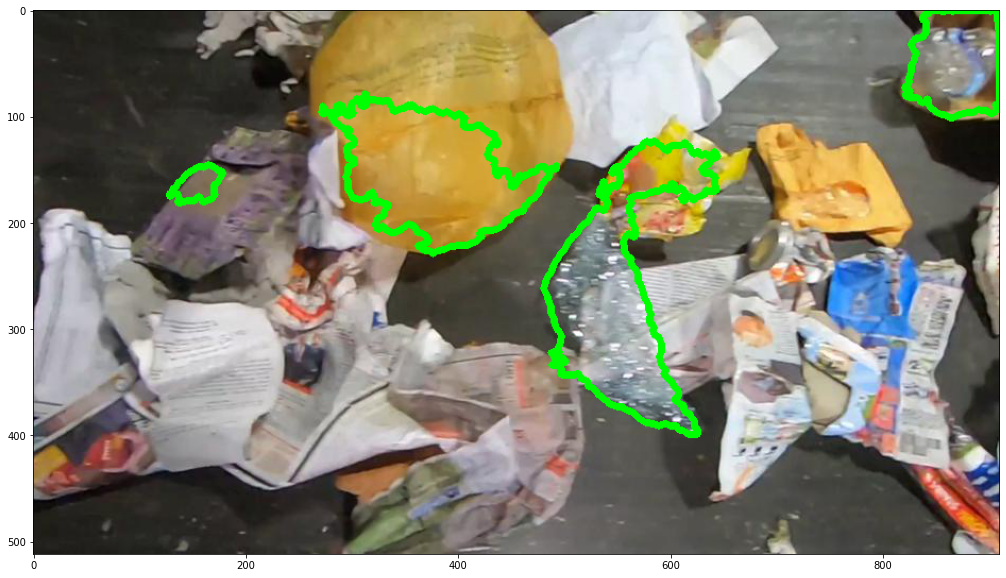

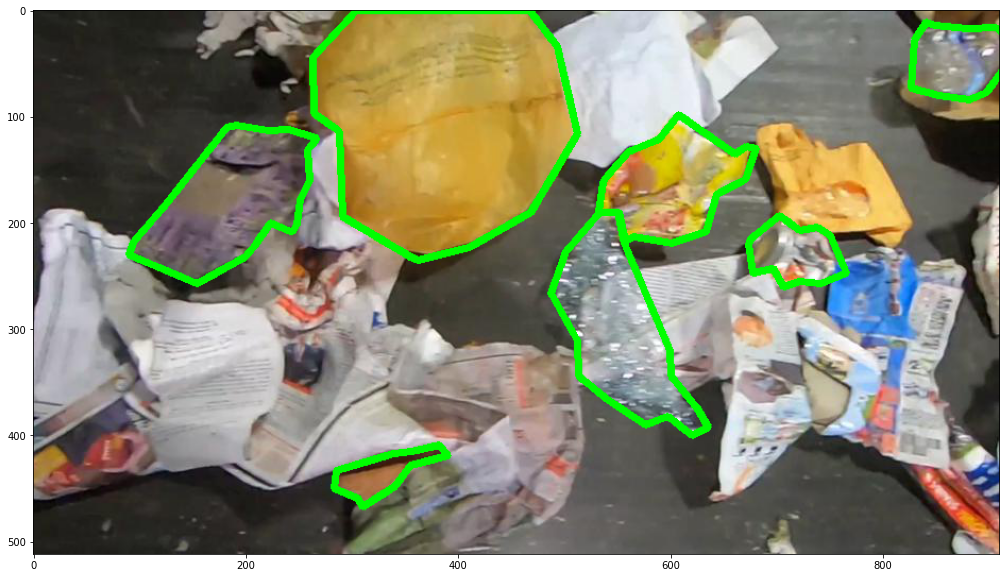

In [ ]:
set_plot_size("big")

idx_test = np.random.randint(909)  # 0, 600
idx_test = 0  # 0, 287, 496, 578
print(idx_test)

name_test = str(idx_test).zfill(5)
img_path = "./images/" + name_test + ".jpg"
path_label = "./labels/" + name_test + ".pkl"

to_tensor = torchvision.transforms.ToTensor()
normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

image = Image.open(img_path)
image = to_tensor(image)
# plt.imshow(image.permute((1, 2, 0)))
# plt.show()
image = normalize(image)

x = image[None].cuda()

model.eval()
y = model(x)
y = torch.sigmoid(y)

y = y.detach().cpu().numpy()
raw = y.copy()
thr = 0.7
y[y > thr] = 1
y[y <= thr] = 0

kernels = np.zeros((3, 512, 910), dtype="uint8")

kernels[0] = y[0, 4]
kernels[1] = y[0, 5]
kernels[2] = y[0, 6]

result_pse = pse(kernels, 100)
plt.imshow(kernels[0])
plt.show()
plt.imshow(kernels[1])
plt.show()
plt.imshow(kernels[2])
plt.show()
plt.imshow(result_pse)
plt.show()

plt.imshow(y[0, 0])
plt.show()
plt.imshow(y[0, 1])
plt.show()
plt.imshow(y[0, 2])
plt.show()
plt.imshow(y[0, 3])
plt.show()

with open(path_label, "rb") as f:
    label_tmp = pickle.load(f)

# canvas = np.zeros((512, 910), dtype="uint8")
# for idx in range(len(label_tmp)):
#     tmp_tmp = np.array(label_tmp[idx][0]).reshape((-1, 2))
#     tmp_tmp = (tmp_tmp / 2.1).astype("int")
#     canvas = cv2.drawContours(canvas, [tmp_tmp], 0, 1, -1)

# plt.imshow(canvas)


# get info_prediction and info_label
num_plg = result_pse.max()
info_prediction = list()
for idx_plg in range(num_plg):
    mask = result_pse == idx_plg + 1
    if (mask.sum() == 0):
        continue
    plg = mask2plg(mask)
    conf = mask2conf(mask, raw)
    category = mask2category(mask, raw)
    info_prediction.append((conf, category, plg))

# visualization
canvas_img = np.array(Image.open(img_path), dtype="uint8")
for idx in range(len(info_prediction)):
    plg = info_prediction[idx][2]
    canvas_img = cv2.drawContours(canvas_img, [plg], 0, (0, 255, 0), 5)
plt.imshow(canvas_img)
plt.show()


info_label = list()
for idx_label_tmp in range(len(label_tmp)):
    tmp = label_tmp[idx_label_tmp]
    plg = (np.array(tmp[0], dtype="int32").reshape((-1, 2)) / 2.1).astype(int)
    category = tmp[1]
    info_label.append((category, plg))

# visualization
canvas_img = np.array(Image.open(img_path), dtype="uint8")
for idx in range(len(info_label)):
    plg = info_label[idx][1]
    canvas_img = cv2.drawContours(canvas_img, [plg], 0, (0, 255, 0), 5)
plt.imshow(canvas_img)
plt.show()

In [ ]:
# ----- #
# history
# ----- #
"""
set_plot_size("small")

idx_test = 1  # 600
ap_sum = 0
counter = 0
for idx_test in range(100):
    try:
        name_test = str(idx_test).zfill(5)
        img_path = "./images/" + name_test + ".jpg"
        path_label = "./labels/" + name_test + ".pkl"

        to_tensor = torchvision.transforms.ToTensor()
        normalize = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        image = Image.open(img_path)
        image = to_tensor(image)
        # plt.imshow(image.permute((1, 2, 0)))
        # plt.show()
        image = normalize(image)

        x = image[None].cuda()

        model.eval()
        y = model(x)
        y = torch.sigmoid(y)

        y = y.detach().cpu().numpy()
        raw = y.copy()
        thr = 0.5
        y[y > thr] = 1
        y[y <= thr] = 0

        kernels = np.zeros((3, 512, 910), dtype="uint8")

        kernels[0] = y[0, 4]
        kernels[1] = y[0, 5]
        kernels[2] = y[0, 6]

        result_pse = pse(kernels, 100)
        # plt.imshow(result_pse)
        # plt.show()

        with open(path_label, "rb") as f:
            label_tmp = pickle.load(f)

        # canvas = np.zeros((512, 910), dtype="uint8")
        # for idx in range(len(label_tmp)):
        #     tmp_tmp = np.array(label_tmp[idx][0]).reshape((-1, 2))
        #     tmp_tmp = (tmp_tmp / 2.1).astype("int")
        #     canvas = cv2.drawContours(canvas, [tmp_tmp], 0, 1, -1)

        # plt.imshow(canvas)


        # get info_prediction and info_label
        num_plg = result_pse.max()
        info_prediction = list()
        for idx_plg in range(num_plg):
            mask = result_pse == idx_plg + 1
            if (mask.sum() == 0):
                continue
            plg = mask2plg(mask)
            conf = mask2conf(mask, raw)
            category = mask2category(mask, raw)
            info_prediction.append((conf, category, plg))

        # visualization
        # canvas_img = np.array(Image.open(img_path), dtype="uint8")
        # for idx in range(len(info_prediction)):
        #     plg = info_prediction[idx][2]
        #     canvas_img = cv2.drawContours(canvas_img, [plg], 0, (255, 0, 0), 5)
        # plt.imshow(canvas_img)
        # plt.show()


        info_label = list()
        for idx_label_tmp in range(len(label_tmp)):
            tmp = label_tmp[idx_label_tmp]
            plg = (np.array(tmp[0], dtype="int32").reshape((-1, 2)) / 2.1).astype(int)
            category = tmp[1]
            info_label.append((category, plg))

        # visualization
        # canvas_img = np.array(Image.open(img_path), dtype="uint8")
        # for idx in range(len(info_label)):
        #     plg = info_label[idx][1]
        #     canvas_img = cv2.drawContours(canvas_img, [plg], 0, (255, 0, 0), 5)
        # plt.imshow(canvas_img)
        # plt.show()

        list_ap_pred = [[tmp[2], tmp[0]] for tmp in info_prediction]
        list_ap_label = [tmp[1] for tmp in info_label]

        ap_current = Average_precision(list_ap_pred, list_ap_label, 0.5)
        print("AP:", ap_current)
        ap_sum += ap_current
        counter += 1
    except:
        pass

ap_sum / counter
"""